In [274]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import statsmodels.api as sm
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from sklearn import metrics

In [275]:
df = pd.read_csv('SetBueno.csv')

In [276]:
df

,Unnamed: 0,index,date,Encoded Products,Cadereyta total $,Cadereyta ctdad,Coahuila total $,Coahuila ctdad,Durango total $,Durango ctdad,...,Queretaro total $,Queretaro ctdad,Reynosa total $,Reynosa ctdad,San Luis total $,San Luis ctdad,Total libre de impuestos,Ctdad Ordenada,Indefinido total $,Indefinido ctdad
0,0,4,2022-01-02,Producto 11,0.00,0.0,0.000,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,18162.13,3.5,58623.600,10.5,NaN,NaN
1,1,5,2022-01-02,Producto 6,0.00,0.0,0.000,0.0,0.0,0.0,...,23477.44,3.5,0.0,0.0,0.00,0.0,23477.440,3.5,NaN,NaN
2,2,6,2022-01-02,Producto 24,0.00,0.0,0.000,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.00,0.0,31083.500,3.5,NaN,NaN
3,3,7,2022-01-02,Producto 15,0.00,0.0,0.000,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.00,0.0,42846.020,7.0,NaN,NaN
4,4,8,2022-01-02,Producto 9,0.00,0.0,27154.855,3.5,0.0,0.0,...,0.00,0.0,0.0,0.0,0.00,0.0,27154.855,3.5,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30560,30560,4317,2023-12-31,Producto 273,0.00,0.0,34740.090,3.5,0.0,0.0,...,0.00,0.0,0.0,0.0,0.00,0.0,60970.805,7.0,NaN,NaN
30561,30561,4318,2023-12-31,Producto 273,35273.21,3.5,0.000,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.00,0.0,35273.210,3.5,NaN,NaN
30562,30562,4319,2023-12-31,Producto 273,0.00,0.0,0.000,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.00,0.0,41274.205,3.5,NaN,NaN
30563,30563,4320,2023-12-31,Producto 273,0.00,0.0,0.000,0.0,0.0,0.0,...,15192.10,3.5,0.0,0.0,0.00,0.0,15192.100,3.5,NaN,NaN


In [277]:
df.columns

Index(['Unnamed: 0', 'index', 'date', 'Encoded Products', 'Cadereyta total $',
       'Cadereyta ctdad', 'Coahuila total $', 'Coahuila ctdad',
       'Durango total $', 'Durango ctdad', 'Expos F total $', 'Expos F ctdad',
       'Laredo total $', 'Laredo ctdad', 'Monterrey total $',
       'Monterrey ctdad', 'Online total $', 'Online ctdad',
       'Queretaro total $', 'Queretaro ctdad', 'Reynosa total $',
       'Reynosa ctdad', 'San Luis total $', 'San Luis ctdad',
       'Total libre de impuestos', 'Ctdad Ordenada', 'Indefinido total $',
       'Indefinido ctdad'],
      dtype='object')

In [278]:
# Lista de ciudades para las que deseas realizar el proceso
ciudades = ['Cadereyta', 'Coahuila', 'Durango', 'Expos F', 'Laredo', 'Monterrey', 'Online',
            'Queretaro', 'Reynosa', 'San Luis']

# Diccionario para mapear los nombres de las columnas antiguas a los nuevos nombres de columnas
nuevos_nombres = {
    'Cadereyta total $': 'total',
    'Cadereyta ctdad': 'ctdad',
    'Coahuila total $': 'total',
    'Coahuila ctdad': 'ctdad',
    'Durango total $': 'total',
    'Durango ctdad': 'ctdad',
    'Expos F total $': 'total',
    'Expos F ctdad': 'ctdad',
    'Laredo total $': 'total',
    'Laredo ctdad': 'ctdad',
    'Monterrey total $': 'total',
    'Monterrey ctdad': 'ctdad',
    'Online total $': 'total',
    'Online ctdad': 'ctdad',
    'Queretaro total $': 'total',
    'Queretaro ctdad': 'ctdad',
    'Reynosa total $': 'total',
    'Reynosa ctdad': 'ctdad',
    'San Luis total $': 'total',
    'San Luis ctdad': 'ctdad',
}

# Crear un diccionario para almacenar los DataFrames modificados para cada ciudad
dfs_por_ciudad = {}

# Iterar sobre cada ciudad y realizar las operaciones necesarias
for ciudad in ciudades:
    # Selecciona las columnas correspondientes a la ciudad actual
    df_ciudad = df[['Encoded Products', 'date', f'{ciudad} total $', f'{ciudad} ctdad']]
    
    # Cambiar el nombre de la columna 'Encoded Products' eliminando 'Producto' y convirtiéndola a entero
    df_ciudad['Encoded Products'] = df['Encoded Products'].str.replace('Producto', '').str.strip()
    df_ciudad['Encoded Products'] = df_ciudad['Encoded Products'].astype(int)
    
    # Agregar una columna 'Ciudad' con el nombre de la ciudad actual para todas las filas
    df_ciudad['Ciudad'] = ciudad
    
    # Cambiar el nombre de las columnas según el diccionario 'nuevos_nombres'
    df_ciudad = df_ciudad.rename(columns=nuevos_nombres)
    
    # Guardar el DataFrame modificado para la ciudad actual en el diccionario 'dfs_por_ciudad'
    dfs_por_ciudad[ciudad] = df_ciudad


C:\Users\jesus\AppData\Local\Temp\ipykernel_1872\3554873387.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ciudad['Encoded Products'] = df['Encoded Products'].str.replace('Producto', '').str.strip()
C:\Users\jesus\AppData\Local\Temp\ipykernel_1872\3554873387.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ciudad['Encoded Products'] = df_ciudad['Encoded Products'].astype(int)
C:\Users\jesus\AppData\Local\Temp\ipykernel_1872\3554873387.py:42: SettingWithCopyWarning: 
A value is trying to be s

In [279]:
df_final = pd.concat(dfs_por_ciudad.values(), ignore_index=True)

In [280]:
df_final

,Encoded Products,date,total,ctdad,Ciudad
0,11,2022-01-02,0.0,0.0,Cadereyta
1,6,2022-01-02,0.0,0.0,Cadereyta
2,24,2022-01-02,0.0,0.0,Cadereyta
3,15,2022-01-02,0.0,0.0,Cadereyta
4,9,2022-01-02,0.0,0.0,Cadereyta
...,...,...,...,...,...
305645,273,2023-12-31,0.0,0.0,San Luis
305646,273,2023-12-31,0.0,0.0,San Luis
305647,273,2023-12-31,0.0,0.0,San Luis
305648,273,2023-12-31,0.0,0.0,San Luis


# EDA

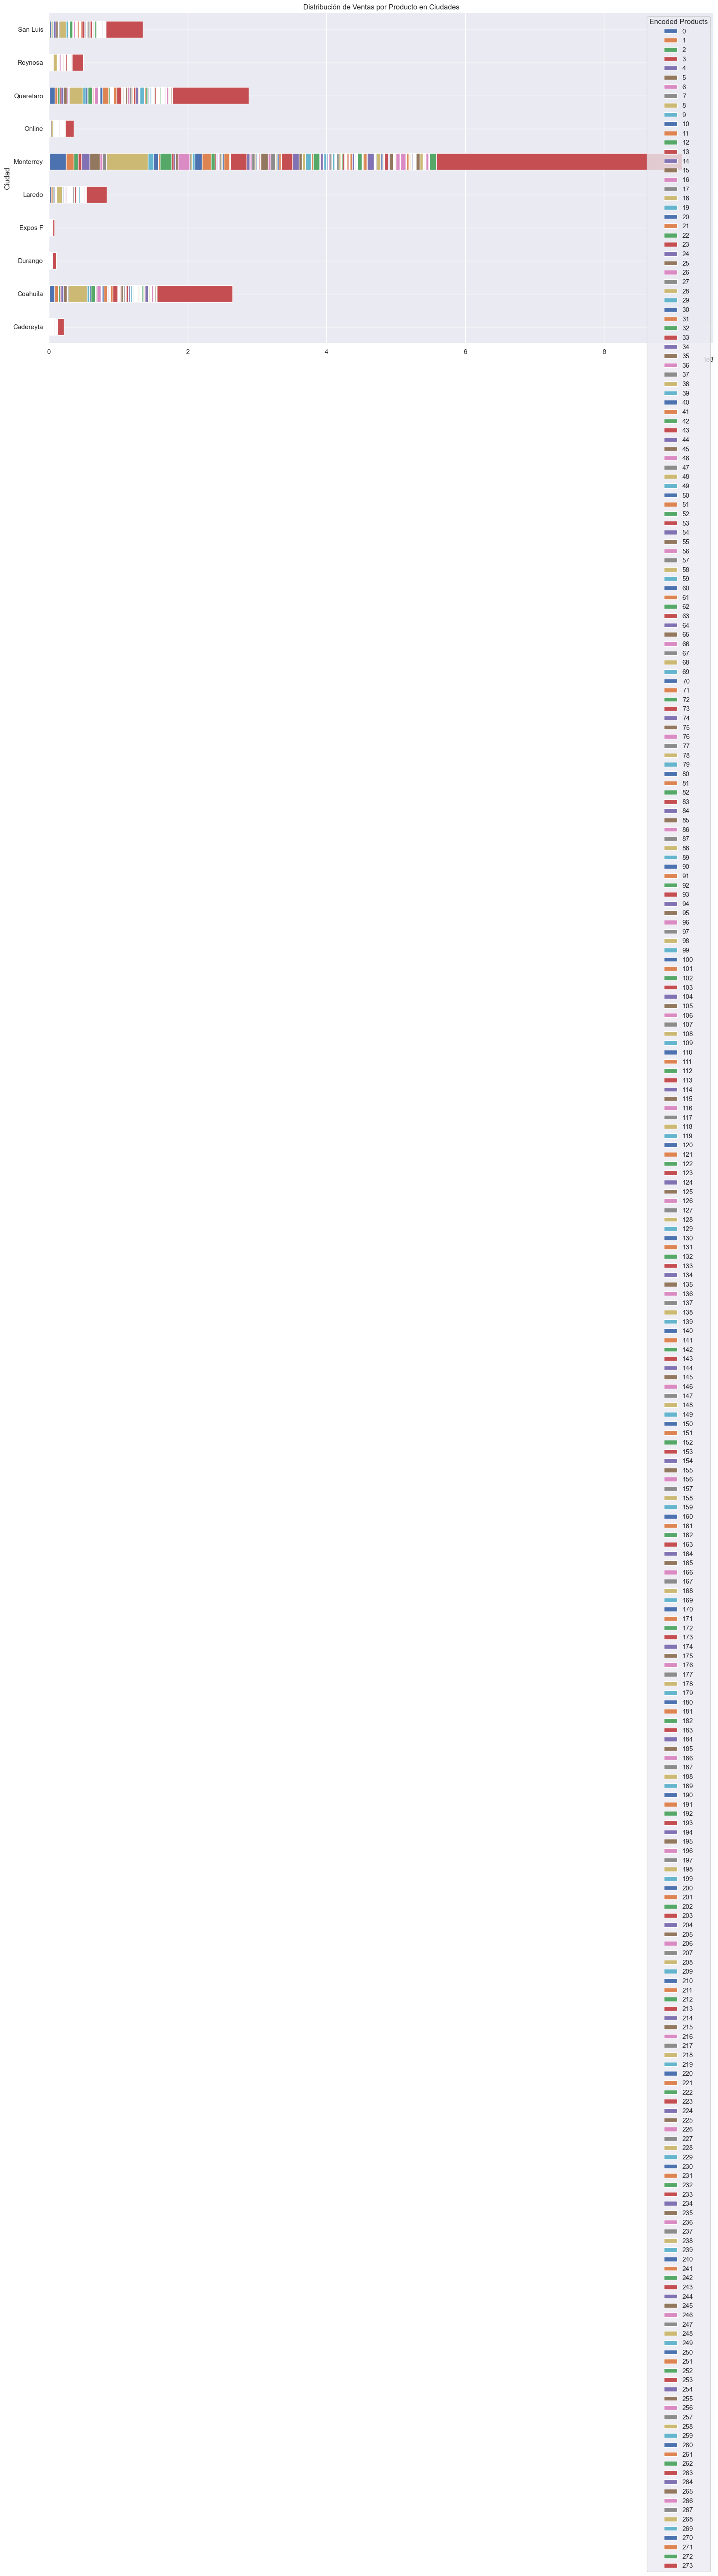

In [281]:
grafica = df_final.groupby(['Ciudad','Encoded Products']).sum().unstack().plot(kind='barh', y='total', stacked=True, figsize=(20, 10))
grafica.set_title('Distribución de Ventas por Producto en Ciudades')
plt.show()

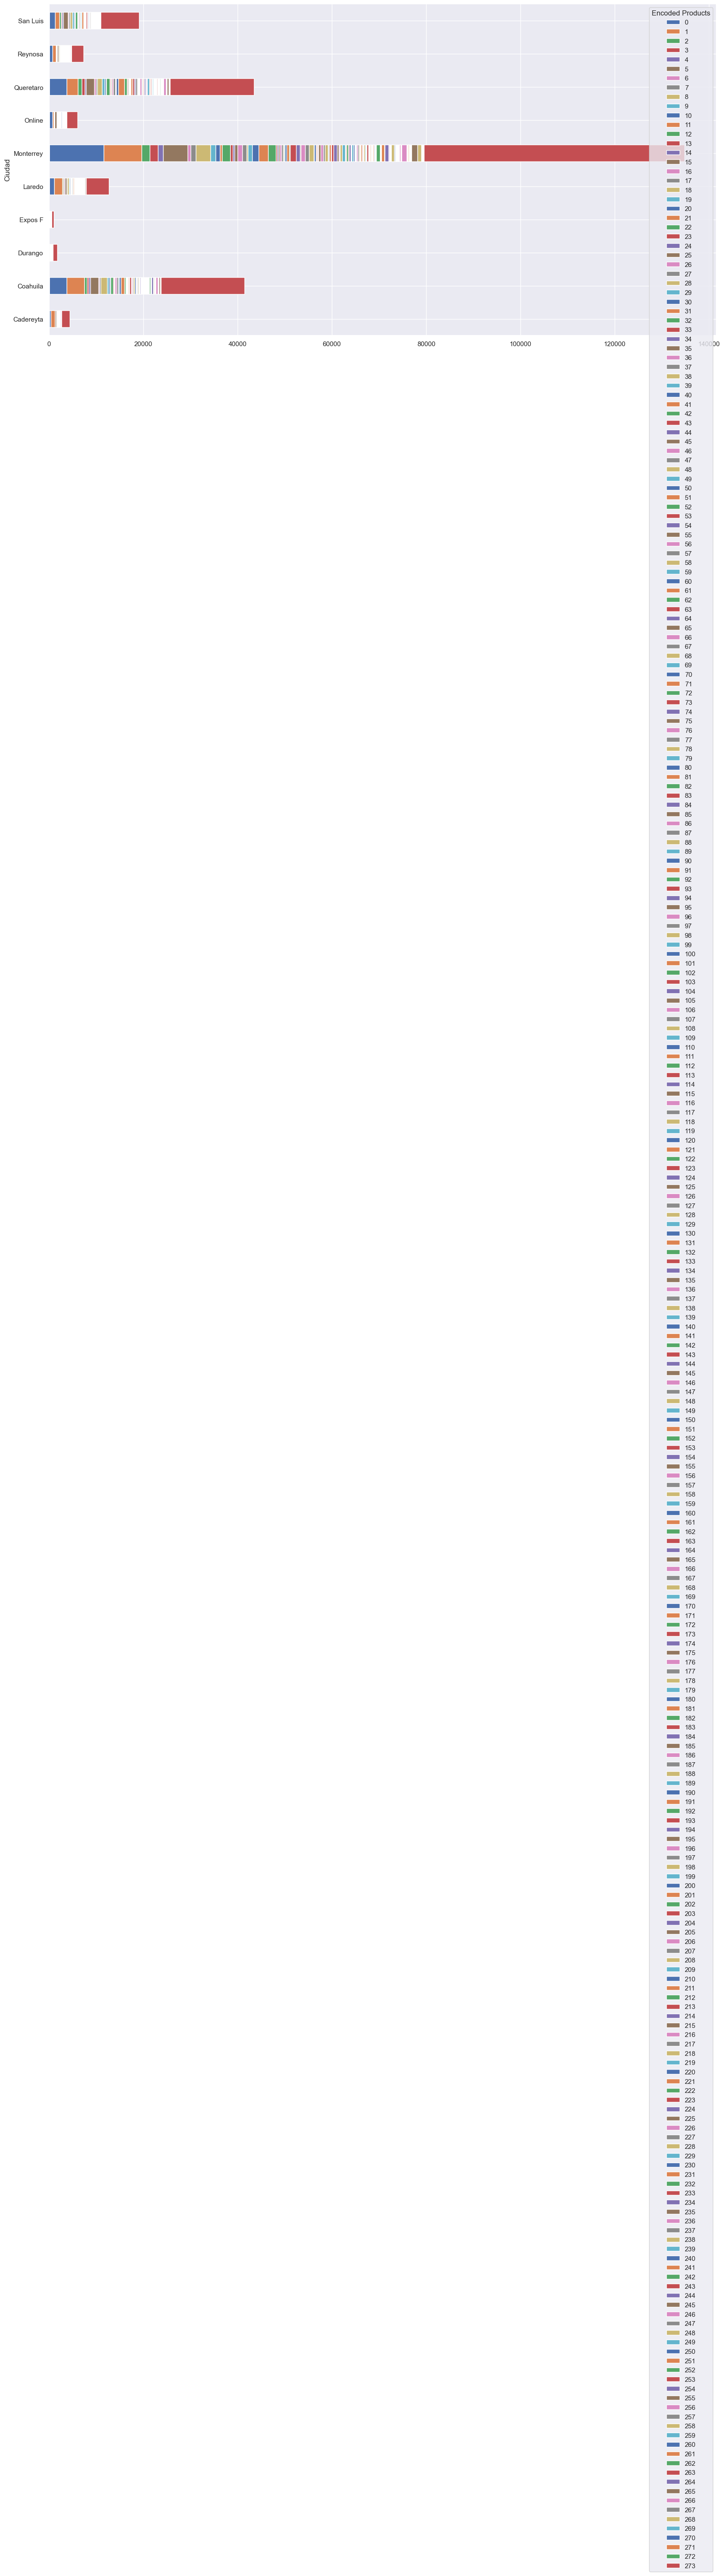

In [282]:
df_final.groupby(['Ciudad','Encoded Products']).sum().unstack().plot(kind='barh',y='ctdad', stacked=True, figsize=(20, 10))
grafica.set_title('Cantidad Vendida por Producto en Ciudades')
plt.show()


In [283]:
df_final.groupby('Ciudad')['ctdad'].sum().sort_values(ascending=False).head(3)

Ciudad
Monterrey    134809.5
Queretaro     43501.5
Coahuila      41450.5
Name: ctdad, dtype: float64

In [284]:
df_final.groupby('Ciudad')['total'].sum().sort_values(ascending=False).head(3)

Ciudad
Monterrey    9.125314e+08
Queretaro    2.876827e+08
Coahuila     2.642039e+08
Name: total, dtype: float64

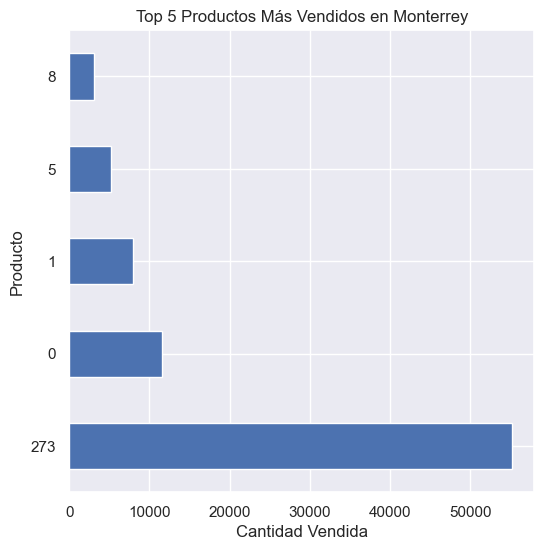

In [285]:
Mty = df_final[df_final['Ciudad'] == 'Monterrey']
# Mty['Encoded Products'] = Mty['Encoded Products'].astype(str)
plt.figure(figsize=(6,6))
Mty.groupby(['Encoded Products'])['ctdad'].sum().sort_values(ascending=False).head(5).plot(kind='barh')
plt.title('Top 5 Productos Más Vendidos en Monterrey')
plt.xlabel('Cantidad Vendida')
plt.ylabel('Producto')
plt.xticks(rotation=0)
plt.show()

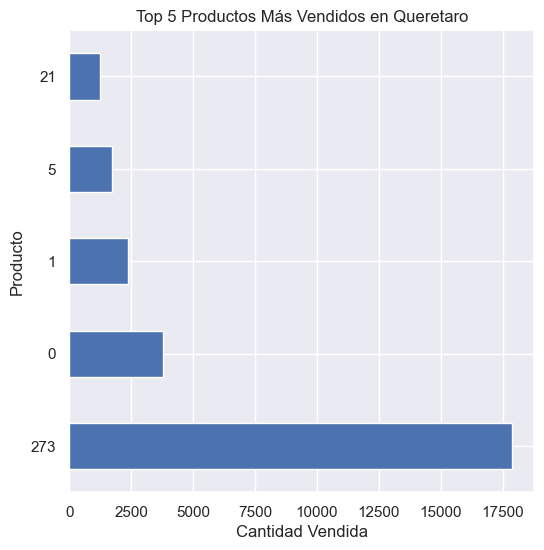

In [286]:
Qro = df_final[df_final['Ciudad'] == 'Queretaro']
# Mty['Encoded Products'] = Mty['Encoded Products'].astype(str)
plt.figure(figsize=(6,6))
Qro.groupby(['Encoded Products'])['ctdad'].sum().sort_values(ascending=False).head(5).plot(kind='barh')
plt.title('Top 5 Productos Más Vendidos en Queretaro')
plt.xlabel('Cantidad Vendida')
plt.ylabel('Producto')
plt.xticks(rotation=0)
plt.show()

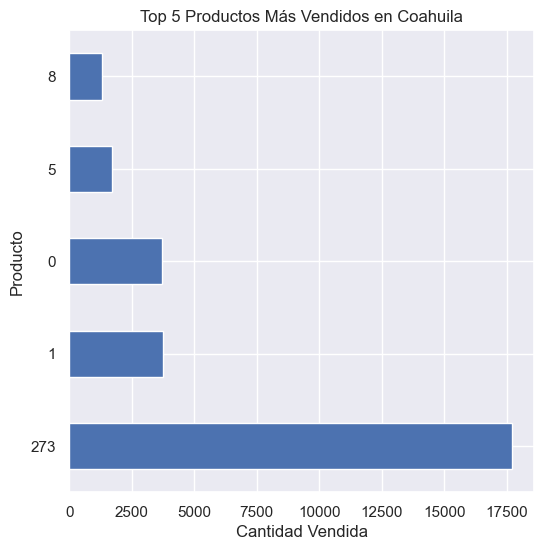

In [287]:
Chl = df_final[df_final['Ciudad'] == 'Coahuila']
# Mty['Encoded Products'] = Mty['Encoded Products'].astype(str)
plt.figure(figsize=(6,6))
Chl.groupby(['Encoded Products'])['ctdad'].sum().sort_values(ascending=False).head(5).plot(kind='barh')
plt.title('Top 5 Productos Más Vendidos en Coahuila')
plt.xlabel('Cantidad Vendida')
plt.ylabel('Producto')
plt.xticks(rotation=0)
plt.show()

In [288]:
df_final['date'] = pd.to_datetime(df_final['date'])
sales_daily = df_final.groupby('date').ctdad.sum()
sales_daily_df = pd.DataFrame(sales_daily)
sales_weekly_mean = sales_daily_df['ctdad'].resample('W').mean()
sales_monthly_mean = sales_daily_df['ctdad'].resample('M').mean()

# Para el weekly

In [289]:
# Suponiendo que tienes un DataFrame llamado df con una columna llamada 'fecha' de tipo datetime
# Aquí están las dos fechas específicas entre las que deseas seleccionar
fecha_inicio = pd.to_datetime('2022-10-03')
fecha_fin = pd.to_datetime('2022-12-30')

# Seleccionar los datos entre las dos fechas especificadas
datos_entre_fechas = sales_weekly_mean[(sales_weekly_mean.index >= fecha_inicio) & (sales_weekly_mean.index <= fecha_fin)]
datos_entre_fechas

date
2022-10-09     307.5
2022-10-16     273.5
2022-10-23     252.5
2022-10-30     262.0
2022-11-06     329.0
2022-11-13     353.0
2022-11-20    1208.5
2022-11-27     867.5
2022-12-04     364.0
2022-12-11     398.5
2022-12-18     451.0
2022-12-25     372.0
Freq: W-SUN, Name: ctdad, dtype: float64

In [290]:
fecha_inicio = pd.to_datetime('2023-10-03')
fecha_fin = pd.to_datetime('2023-12-30')

# Seleccionar los datos entre las dos fechas especificadas
datos_entre_fechas = sales_weekly_mean[(sales_weekly_mean.index >= fecha_inicio) & (sales_weekly_mean.index <= fecha_fin)]
datos_entre_fechas

date
2023-10-08     326.0
2023-10-15     328.0
2023-10-22     331.5
2023-10-29     316.5
2023-11-05     375.0
2023-11-12     333.5
2023-11-19    1317.5
2023-11-26     824.0
2023-12-03     383.0
2023-12-10     362.0
2023-12-17     441.5
2023-12-24     481.0
Freq: W-SUN, Name: ctdad, dtype: float64

In [291]:

fecha_inicio_01 = pd.to_datetime('2022-10-01')
fecha_fin_01 = pd.to_datetime('2022-12-30')
fecha_inicio_02 = pd.to_datetime('2023-10-01')
fecha_fin_02 = pd.to_datetime('2023-12-30')

# Seleccionar los datos entre las fechas 1
selection_1 = sales_weekly_mean[(sales_weekly_mean.index >= fecha_inicio_02) & (sales_weekly_mean.index <= fecha_fin_02)]

# Asignar los valores de 'Ctdad Ordenada' de selection_1 a las fechas correspondientes en product
sales_weekly_mean[(sales_weekly_mean.index >= fecha_inicio_01) & (sales_weekly_mean.index <= fecha_fin_01)] = selection_1.values



In [292]:
fecha_inicio = pd.to_datetime('2022-10-03')
fecha_fin = pd.to_datetime('2022-12-30')

# Seleccionar los datos entre las dos fechas especificadas
datos_entre_fechas = sales_weekly_mean[(sales_weekly_mean.index >= fecha_inicio) & (sales_weekly_mean.index <= fecha_fin)]
datos_entre_fechas

date
2022-10-09     326.0
2022-10-16     328.0
2022-10-23     331.5
2022-10-30     316.5
2022-11-06     375.0
2022-11-13     333.5
2022-11-20    1317.5
2022-11-27     824.0
2022-12-04     383.0
2022-12-11     362.0
2022-12-18     441.5
2022-12-25     481.0
Freq: W-SUN, Name: ctdad, dtype: float64

In [293]:
fecha_inicio = pd.to_datetime('2023-10-03')
fecha_fin = pd.to_datetime('2023-12-30')

# Seleccionar los datos entre las dos fechas especificadas
datos_entre_fechas = sales_weekly_mean[(sales_weekly_mean.index >= fecha_inicio) & (sales_weekly_mean.index <= fecha_fin)]
datos_entre_fechas

date
2023-10-08     326.0
2023-10-15     328.0
2023-10-22     331.5
2023-10-29     316.5
2023-11-05     375.0
2023-11-12     333.5
2023-11-19    1317.5
2023-11-26     824.0
2023-12-03     383.0
2023-12-10     362.0
2023-12-17     441.5
2023-12-24     481.0
Freq: W-SUN, Name: ctdad, dtype: float64

# Para el monthly

In [294]:
# Suponiendo que tienes un DataFrame llamado df con una columna llamada 'fecha' de tipo datetime
# Aquí están las dos fechas específicas entre las que deseas seleccionar
fecha_inicio = pd.to_datetime('2022-10-03')
fecha_fin = pd.to_datetime('2022-12-30')

# Seleccionar los datos entre las dos fechas especificadas
datos_entre_fechas = sales_monthly_mean[(sales_monthly_mean.index >= fecha_inicio) & (sales_monthly_mean.index <= fecha_fin)]
datos_entre_fechas

date
2022-10-31    283.274194
2022-11-30    669.550000
Freq: M, Name: ctdad, dtype: float64

In [295]:
fecha_inicio = pd.to_datetime('2023-10-03')
fecha_fin = pd.to_datetime('2023-12-30')

# Seleccionar los datos entre las dos fechas especificadas
datos_entre_fechas = sales_monthly_mean[(sales_monthly_mean.index >= fecha_inicio) & (sales_monthly_mean.index <= fecha_fin)]
datos_entre_fechas

date
2023-10-31    325.83871
2023-11-30    690.55000
Freq: M, Name: ctdad, dtype: float64

In [296]:

fecha_inicio_01 = pd.to_datetime('2022-10-01')
fecha_fin_01 = pd.to_datetime('2022-12-30')
fecha_inicio_02 = pd.to_datetime('2023-10-01')
fecha_fin_02 = pd.to_datetime('2023-12-30')

# Seleccionar los datos entre las fechas 1
selection_1 = sales_monthly_mean[(sales_monthly_mean.index >= fecha_inicio_02) & (sales_monthly_mean.index <= fecha_fin_02)]

# Asignar los valores de 'Ctdad Ordenada' de selection_1 a las fechas correspondientes en product
sales_monthly_mean[(sales_monthly_mean.index >= fecha_inicio_01) & (sales_monthly_mean.index <= fecha_fin_01)] = selection_1.values



In [297]:
# Suponiendo que tienes un DataFrame llamado df con una columna llamada 'fecha' de tipo datetime
# Aquí están las dos fechas específicas entre las que deseas seleccionar
fecha_inicio = pd.to_datetime('2022-10-03')
fecha_fin = pd.to_datetime('2022-12-30')

# Seleccionar los datos entre las dos fechas especificadas
datos_entre_fechas = sales_monthly_mean[(sales_monthly_mean.index >= fecha_inicio) & (sales_monthly_mean.index <= fecha_fin)]
datos_entre_fechas

date
2022-10-31    325.83871
2022-11-30    690.55000
Freq: M, Name: ctdad, dtype: float64

# Forecast todas las regiones, todos los productos

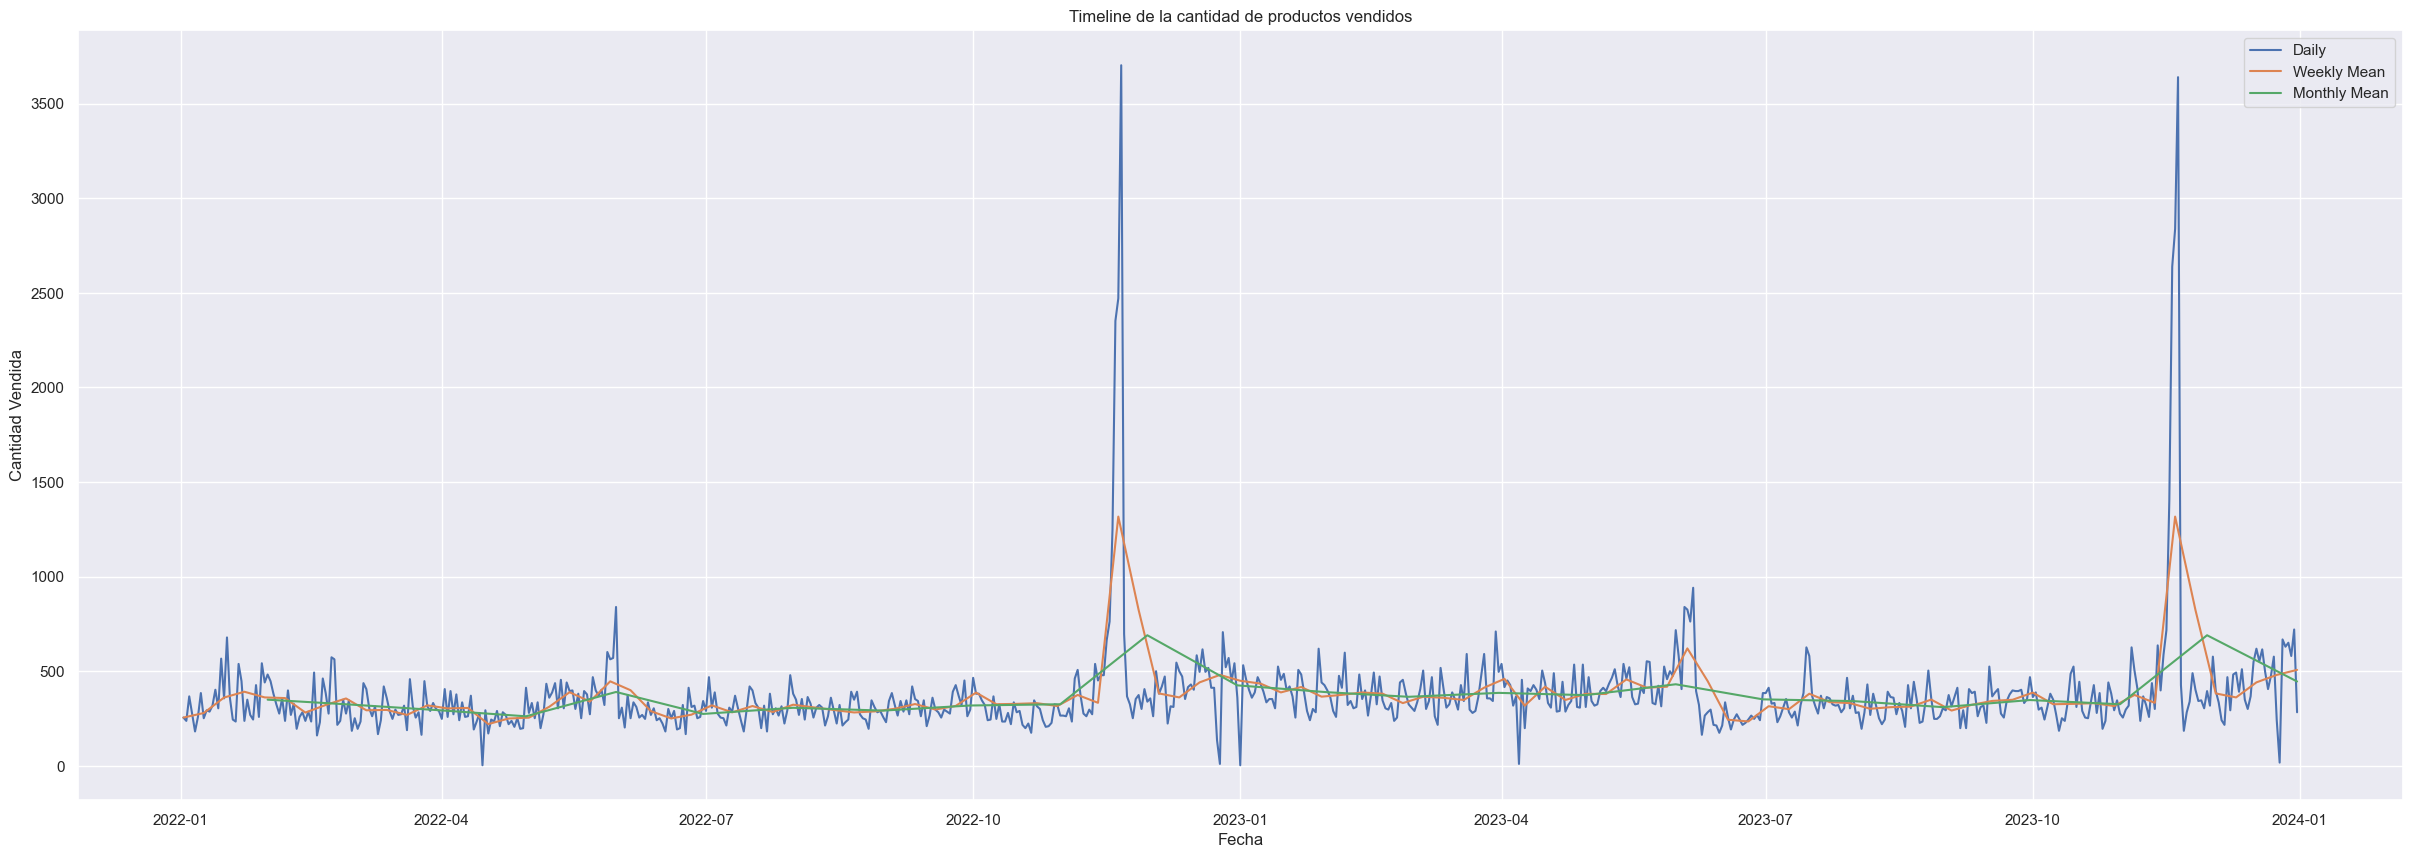

In [298]:
plt.figure(figsize=(30, 10))
plt.plot(sales_daily, label='Daily')
plt.plot(sales_weekly_mean, label='Weekly Mean')
plt.plot(sales_monthly_mean, label='Monthly Mean')
plt.title('Timeline de la cantidad de productos vendidos')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Vendida')
plt.legend()
plt.show()

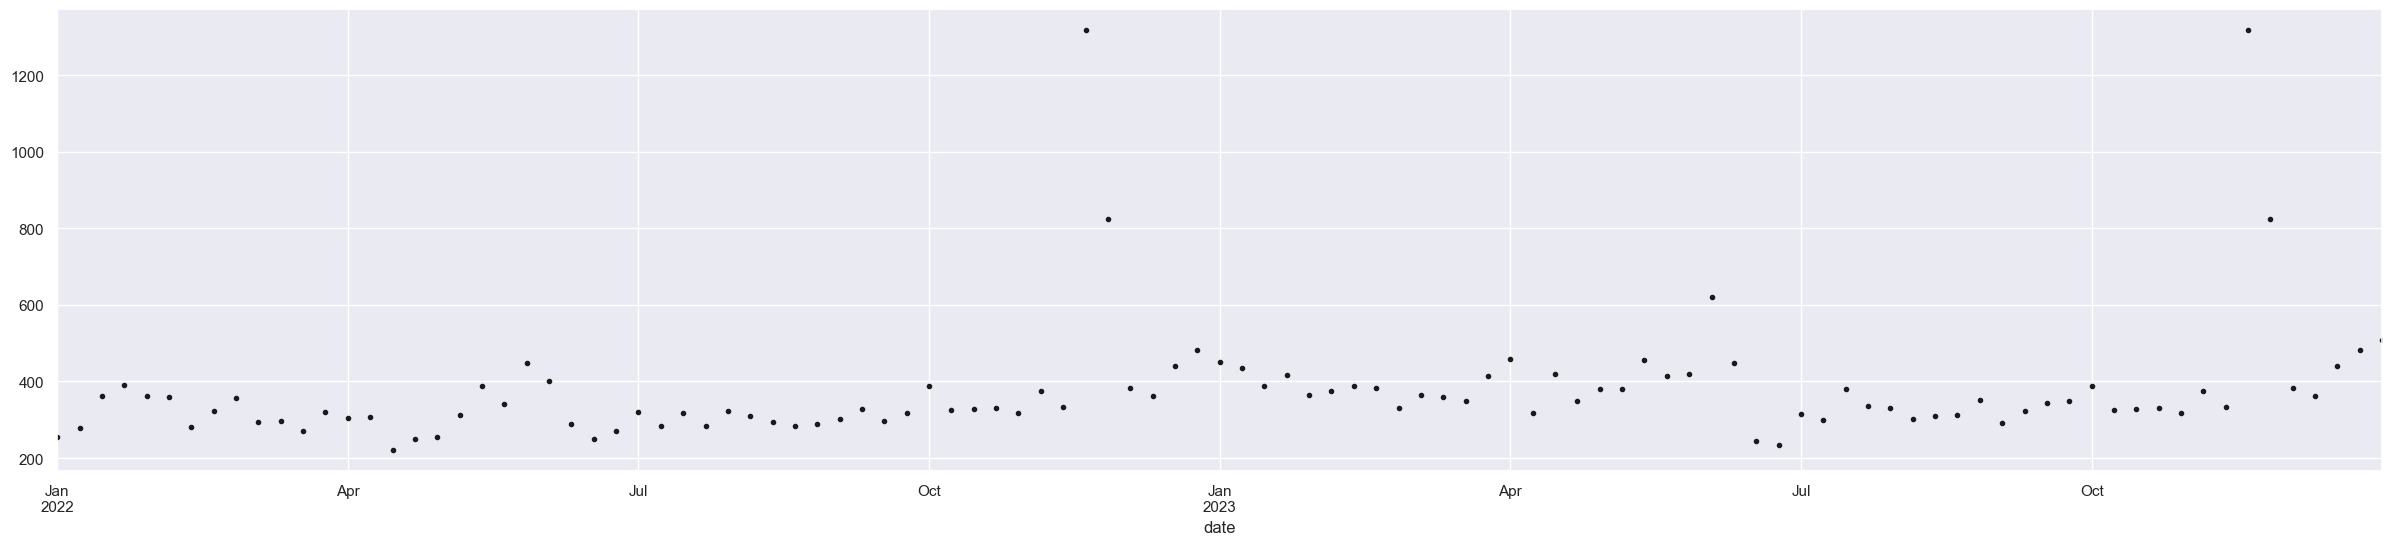

In [299]:
sales_weekly_mean.plot(style='k.', figsize=(30, 6))
plt.show()

In [300]:
sales_monthly = df_final.groupby([df_final['date'].dt.year.rename('year'), df_final['date'].dt.to_period("M").rename('month')])['ctdad'].sum().reset_index()
sales_monthly['month'] = sales_monthly['month'].astype(str)

In [301]:
sales_weekly = df_final.groupby([df_final['date'].dt.year.rename('year'), df_final['date'].dt.to_period("W").rename('week')])['ctdad'].sum().reset_index()
sales_weekly['week'] = sales_weekly['week'].astype(str)

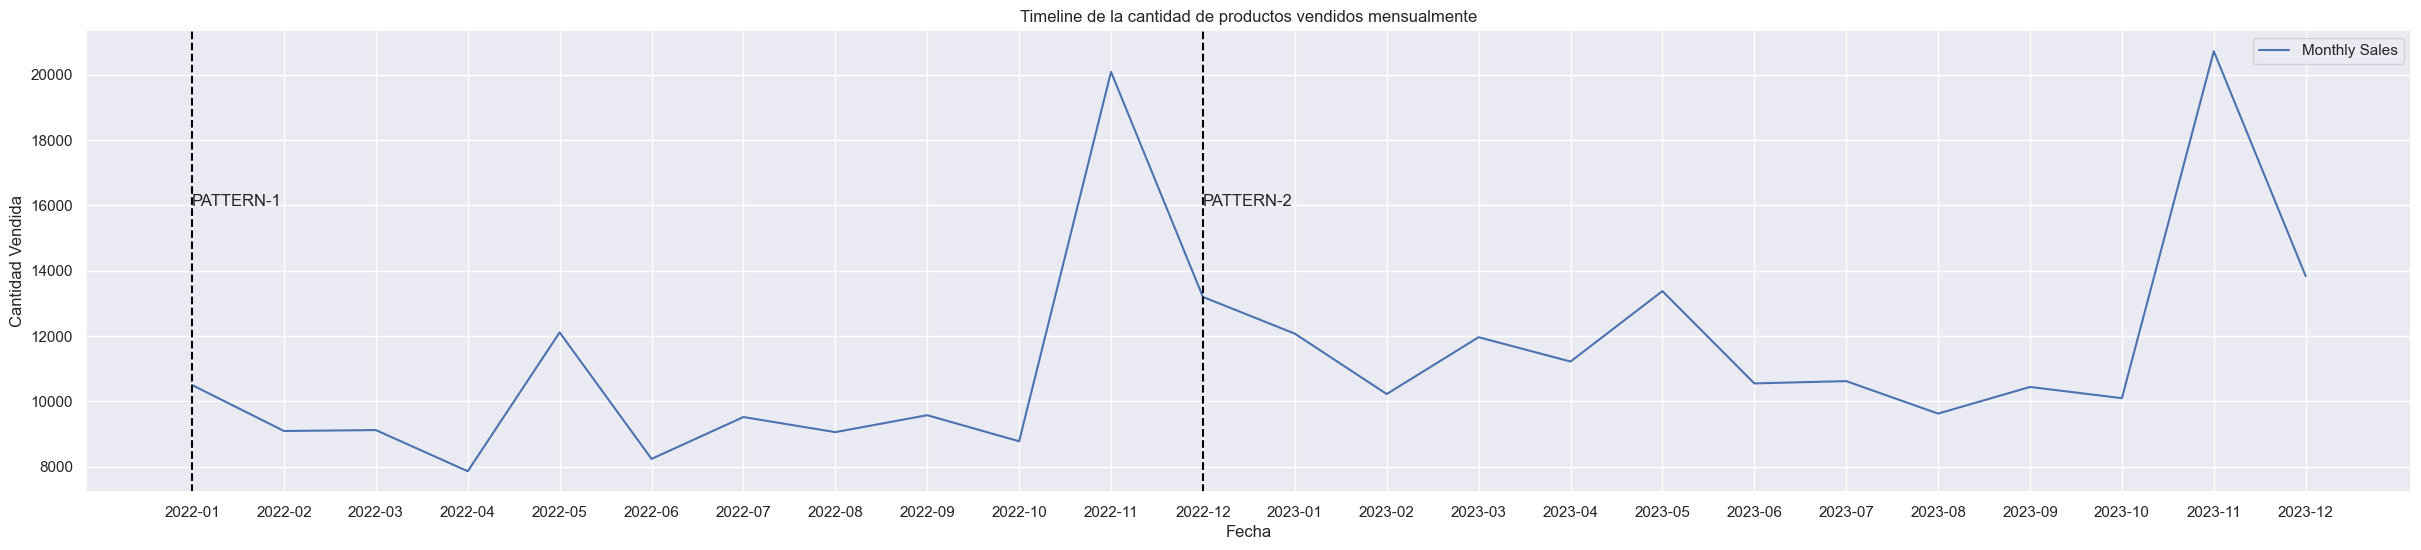

In [302]:
plt.figure(figsize=(30, 6))
plt.plot(sales_monthly['month'],sales_monthly['ctdad'], label='Monthly Sales')
plt.legend()

xcoords = ['2022-01', '2022-12']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')
    
plt.annotate('PATTERN-1', ('2022-01', 16000))
plt.annotate('PATTERN-2', ('2022-12', 16000))

plt.annotate('', ('2023-12', 16000))

# plt.annotate('Similiar to PATTERN-1', ('2018-02', 700000))
# plt.annotate('Similiar to PATTERN-2', ('2018-05', 700000))
# plt.annotate('Possible PATTERN-3?', ('2018-08', 750000))

plt.title('Timeline de la cantidad de productos vendidos mensualmente')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Vendida')

plt.show()

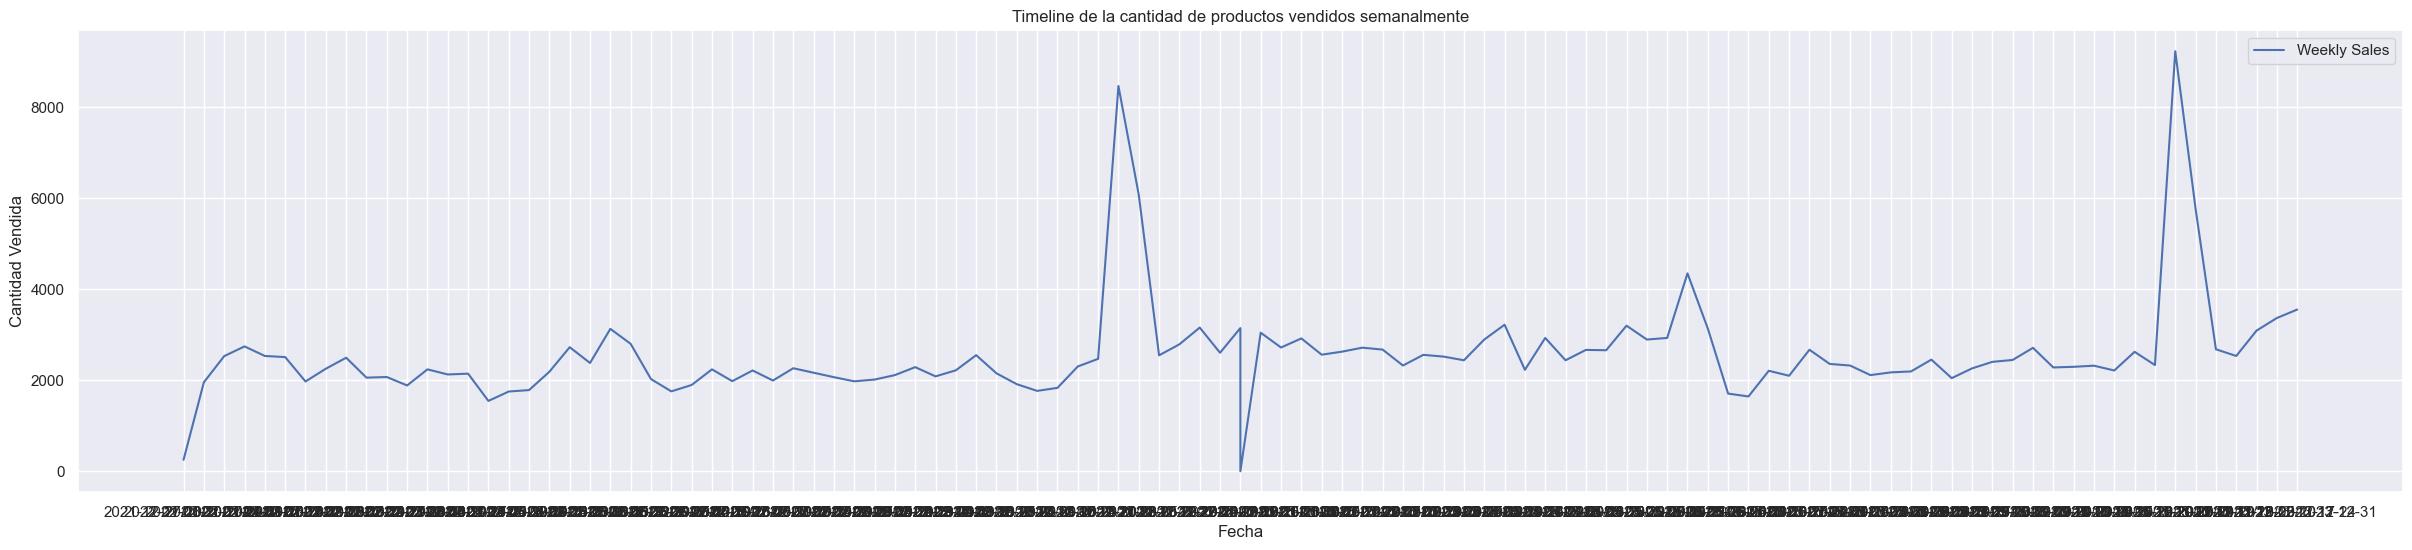

In [303]:
plt.figure(figsize=(30, 6))
plt.plot(sales_weekly['week'],sales_weekly['ctdad'], label='Weekly Sales')
plt.title('Timeline de la cantidad de productos vendidos semanalmente')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Vendida')
plt.legend()

In [304]:
sales_weekly = pd.DataFrame(df_final.groupby([df_final['date'].dt.year.rename('year'), df_final['date'].dt.to_period("W").rename('week')])['ctdad'].sum().reset_index().drop('year', axis=1).set_index('week'))
sales_weekly

,ctdad
week,
2021-12-27/2022-01-02,255.5
2022-01-03/2022-01-09,1956.5
2022-01-10/2022-01-16,2530.5
2022-01-17/2022-01-23,2744.0
2022-01-24/2022-01-30,2534.0
...,...
2023-11-27/2023-12-03,2681.0
2023-12-04/2023-12-10,2534.0
2023-12-11/2023-12-17,3090.5


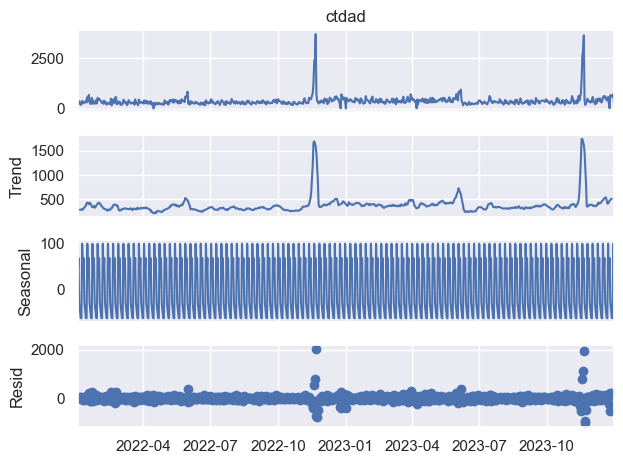

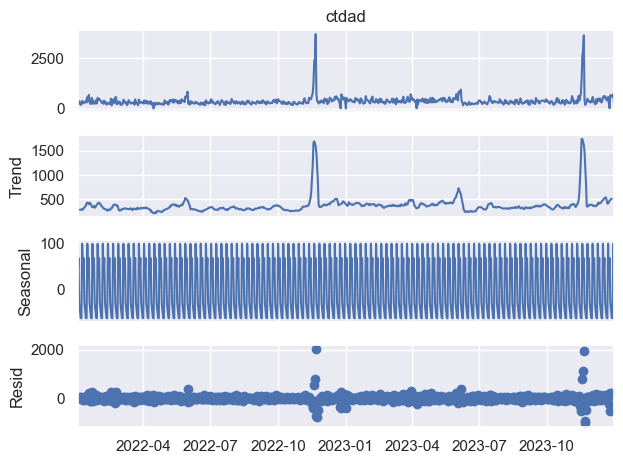

In [305]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_data = seasonal_decompose(sales_daily, model="additive")
decompose_data.plot()

In [306]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(sales_daily, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -8.208417865839433
2. P-Value :  6.923237357227161e-13
3. Num Of Lags :  7
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 721
5. Critical Values :
	 1% :  -3.4394522667904153
	 5% :  -2.8655569894909805
	 10% :  -2.568909106765338


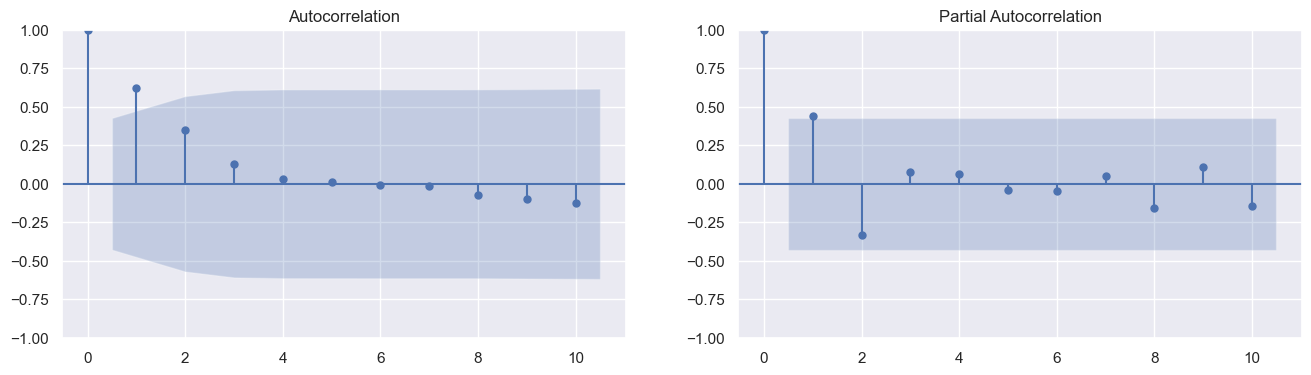

In [307]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

lag_acf = acf(sales_daily, nlags=20)
lag_pacf = pacf(sales_daily, nlags=20, method='ols')

fig, ax = plt.subplots(1,2,figsize=(16,4))
plot_acf(lag_acf, ax=ax[0])
plot_pacf(lag_pacf, ax=ax[1])


plt.show()

In [308]:
arima_model=auto_arima(sales_weekly_mean, start_p=1,d=1,start_q=1,
                      max_p=5,max_q=5,max_d=5,m=12,
                        start_P=0,D=1,start_Q=0,max_P=5,max_D=5,max_Q=5,
                      seasonal=True,
                       trace=True,
                      error_action="ignore",
                      suppress_warnings=True,
                      stepwise=True,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1261.069, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1236.196, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1220.920, Time=0.23 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1250.786, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1221.732, Time=0.63 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1222.178, Time=1.00 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1223.916, Time=0.32 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.89 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1233.394, Time=0.08 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.16 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=inf, Time=0.17 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1231.211, Time=0.18 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=1

In [309]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  105
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -607.460
Date:                            Tue, 12 Mar 2024   AIC                           1220.920
Time:                                    19:28:44   BIC                           1228.485
Sample:                                01-02-2022   HQIC                          1223.973
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7446      0.058    -12.883      0.000      -0.858      -0.631
ma.S.L12      -0.7796      0.111     -7.044      0.000      -0.997      -0.563
sigma2      2.812e+04   1569.334     17.920      0.000     2.5e+04    3.12e+04
===================================================================================
Ljung-Box (L1) (Q):                   6.05   Jarque-Bera (JB):              1410.34
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):              12.47   Skew:                             3.52
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [310]:
month_number = sales_weekly_mean.index.month

# Convierte la serie de números de mes en una variable exógena DataFrame
exog_variable_month = pd.DataFrame(month_number, index=sales_weekly_mean.index)

In [311]:
exog_variables = pd.concat([exog_variable_month], axis=1)

In [312]:
from sklearn.model_selection import train_test_split
size=int(len(sales_weekly_mean)*0.66)
#train_exog, test_exog = train_test_split(exog_variables, test_size = 0.10, shuffle = False)
train_exog,test_exog=exog_variables[0:size],exog_variables[size:len(exog_variables)]

In [313]:
size=int(len(sales_weekly_mean)*0.66)
X_train,X_test=sales_weekly_mean[0:size],sales_weekly_mean[size:len(sales_weekly_mean)]

model=SARIMAX(X_train,
             exog=train_exog,
             order=(0,1,1),
             seasonal_order=(0,1,1,12))
result=model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              ctdad   No. Observations:                   69
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -364.888
Date:                            Tue, 12 Mar 2024   AIC                            737.777
Time:                                    19:28:45   BIC                            745.878
Sample:                                01-02-2022   HQIC                           740.918
                                     - 04-23-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
date           8.4089     28.271      0.297      0.766     -47.002      63.819
ma.L1         -0.7644      0.062    -12.276      0.000      -0.886      -0.642
ma.S.L12      -0.9973     24.031     -0.042      0.967     -48.098      46.103
sigma2      1.834e+04   4.39e+05      0.042      0.967   -8.43e+05    8.79e+05
===================================================================================
Ljung-Box (L1) (Q):                   3.37   Jarque-Bera (JB):              1590.87
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                             4.26
Prob(H) (two-sided):                  0.47   Kurtosis:                        27.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [314]:
start_index=0
end_index=len(X_train)-1
train_prediction=result.predict(start_index,end_index, exog = train_exog)

st_index=len(X_train)
ed_index=len(sales_weekly_mean)-1
prediction=result.predict(st_index,ed_index, exog = test_exog)

<Axes: xlabel='date'>

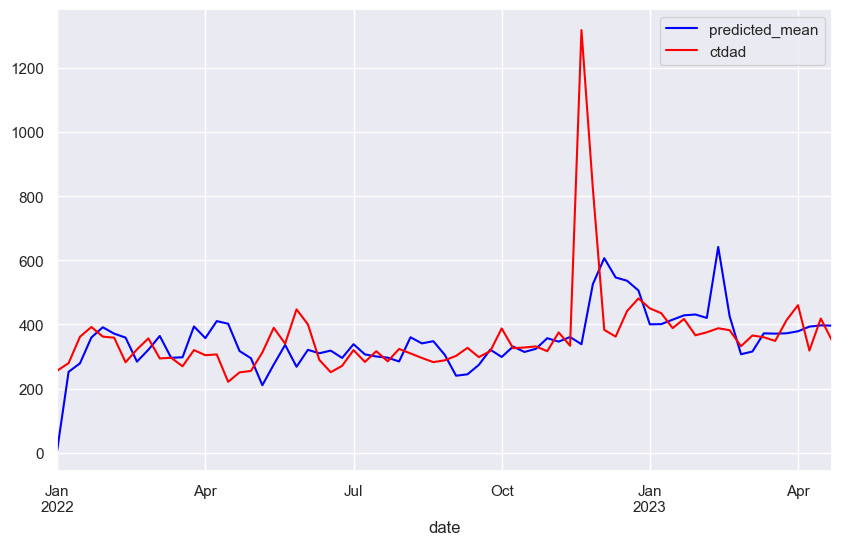

In [315]:
plt.figure(figsize=(10, 6))
train_prediction.plot(legend=True, color='blue')
X_train.plot(legend=True, color = 'red')

In [316]:
print('Absolute Error:', metrics.mean_absolute_error(X_train, train_prediction))
print('MSE:', metrics.mean_squared_error(X_train, train_prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(X_train, train_prediction)))

Absolute Error: 74.93371307236181
MSE: 21503.050032830117
RMSE: 146.63918314294483


<Axes: xlabel='date'>

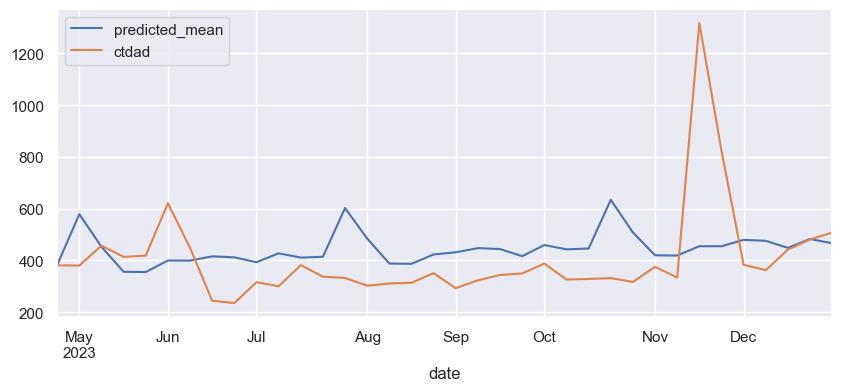

In [317]:
plt.figure(figsize=(10, 4))
prediction.plot(legend=True)
X_test.plot(legend=True)

In [318]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Suponiendo que X_test son los valores verdaderos y prediction son los valores predichos

# Calcula el MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(X_test, prediction)
print('MAPE:', mape)

# Calcula el COD (Coefficient of Determination)
cod = r2_score(X_test, prediction)
# print('COD:', cod)
print('Absolute Error:', metrics.mean_absolute_error(X_test, prediction))
print('MSE:', metrics.mean_squared_error(X_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(X_test, prediction)))

MAPE: 32.59338062947714
Absolute Error: 132.83988905515793
MSE: 39850.47669722143
RMSE: 199.6258417570767


In [319]:
date_range = pd.date_range(start='2024-01-01', periods=92, freq='W')

# Extrae el número de mes de cada fecha en el rango
exog_data = pd.DataFrame({'date': date_range})
exog_data['month'] = exog_data['date'].dt.month

# Asegúrate de que la columna 'date' sea el índice del DataFrame
exog_data.set_index('date', inplace=True)

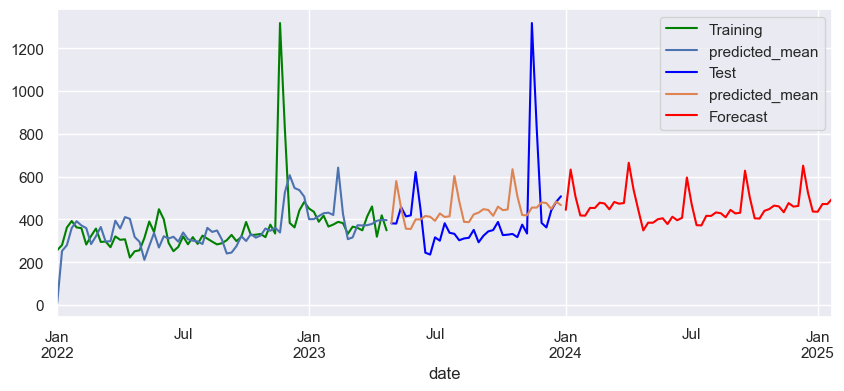

In [320]:
forecast=result.predict(len(sales_weekly_mean), (len(sales_weekly_mean)-1)+56, exog = exog_data).rename('Forecast')

plt.figure(figsize=(10,4))

X_train.plot(label="Training",color='green')
train_prediction.plot(legend=True)
X_test.plot(label="Test",color='blue')
prediction.plot(legend=True)
forecast.plot(label="Forecast",color="red")
plt.legend(loc="upper right")

# Para el producto 273, en todas las regiones

In [321]:
# Supongamos que df es tu DataFrame original con una columna llamada 'timestamp'
# Asegúrate de ordenar el DataFrame por la columna de timestamp
df_final_new = df_final.sort_values('date')

# Crea un nuevo DataFrame con un rango de fechas desde la fecha mínima hasta la fecha máxima en tu DataFrame original
fecha_min = df_final_new['date'].min()
fecha_max = df_final_new['date'].max()
rango_fechas = pd.date_range(start=fecha_min, end=fecha_max, freq='D')
df_rango_fechas = pd.DataFrame({'date': rango_fechas})

# Fusiona el nuevo DataFrame con tu DataFrame original
df_final_new = pd.merge(df_rango_fechas, df_final_new, on='date', how='left')

# Rellena los valores NaN con las fechas faltantes
df_final_new['date'] = df_final_new['date'].fillna(method='ffill')
df_final_new.fillna(0, inplace=True)
df_final_new

C:\Users\jesus\AppData\Local\Temp\ipykernel_1872\2222890867.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_final_new['date'] = df_final_new['date'].fillna(method='ffill')


,date,Encoded Products,total,ctdad,Ciudad
0,2022-01-02,11,0.000,0.0,Cadereyta
1,2022-01-02,79,65930.935,3.5,Monterrey
2,2022-01-02,16,53339.440,3.5,Monterrey
3,2022-01-02,8,207726.435,10.5,Monterrey
4,2022-01-02,117,25646.075,3.5,Monterrey
...,...,...,...,...,...
305645,2023-12-31,273,0.000,0.0,Online
305646,2023-12-31,273,0.000,0.0,Online
305647,2023-12-31,273,0.000,0.0,Online
305648,2023-12-31,273,26230.715,3.5,Monterrey


In [322]:
df_final_new['date'] = pd.to_datetime(df_final_new['date'])
sales_daily = df_final_new.groupby('date').ctdad.sum()
sales_daily_df = pd.DataFrame(sales_daily)
sales_weekly_mean = sales_daily_df['ctdad'].resample('W').mean()
sales_monthly_mean = sales_daily_df['ctdad'].resample('M').mean()


In [323]:
sales_daily

date
2022-01-02    255.5
2022-01-03    238.0
2022-01-04    367.5
2022-01-05    273.0
2022-01-06    182.0
              ...  
2023-12-27    630.0
2023-12-28    651.0
2023-12-29    581.0
2023-12-30    721.0
2023-12-31    283.5
Name: ctdad, Length: 729, dtype: float64

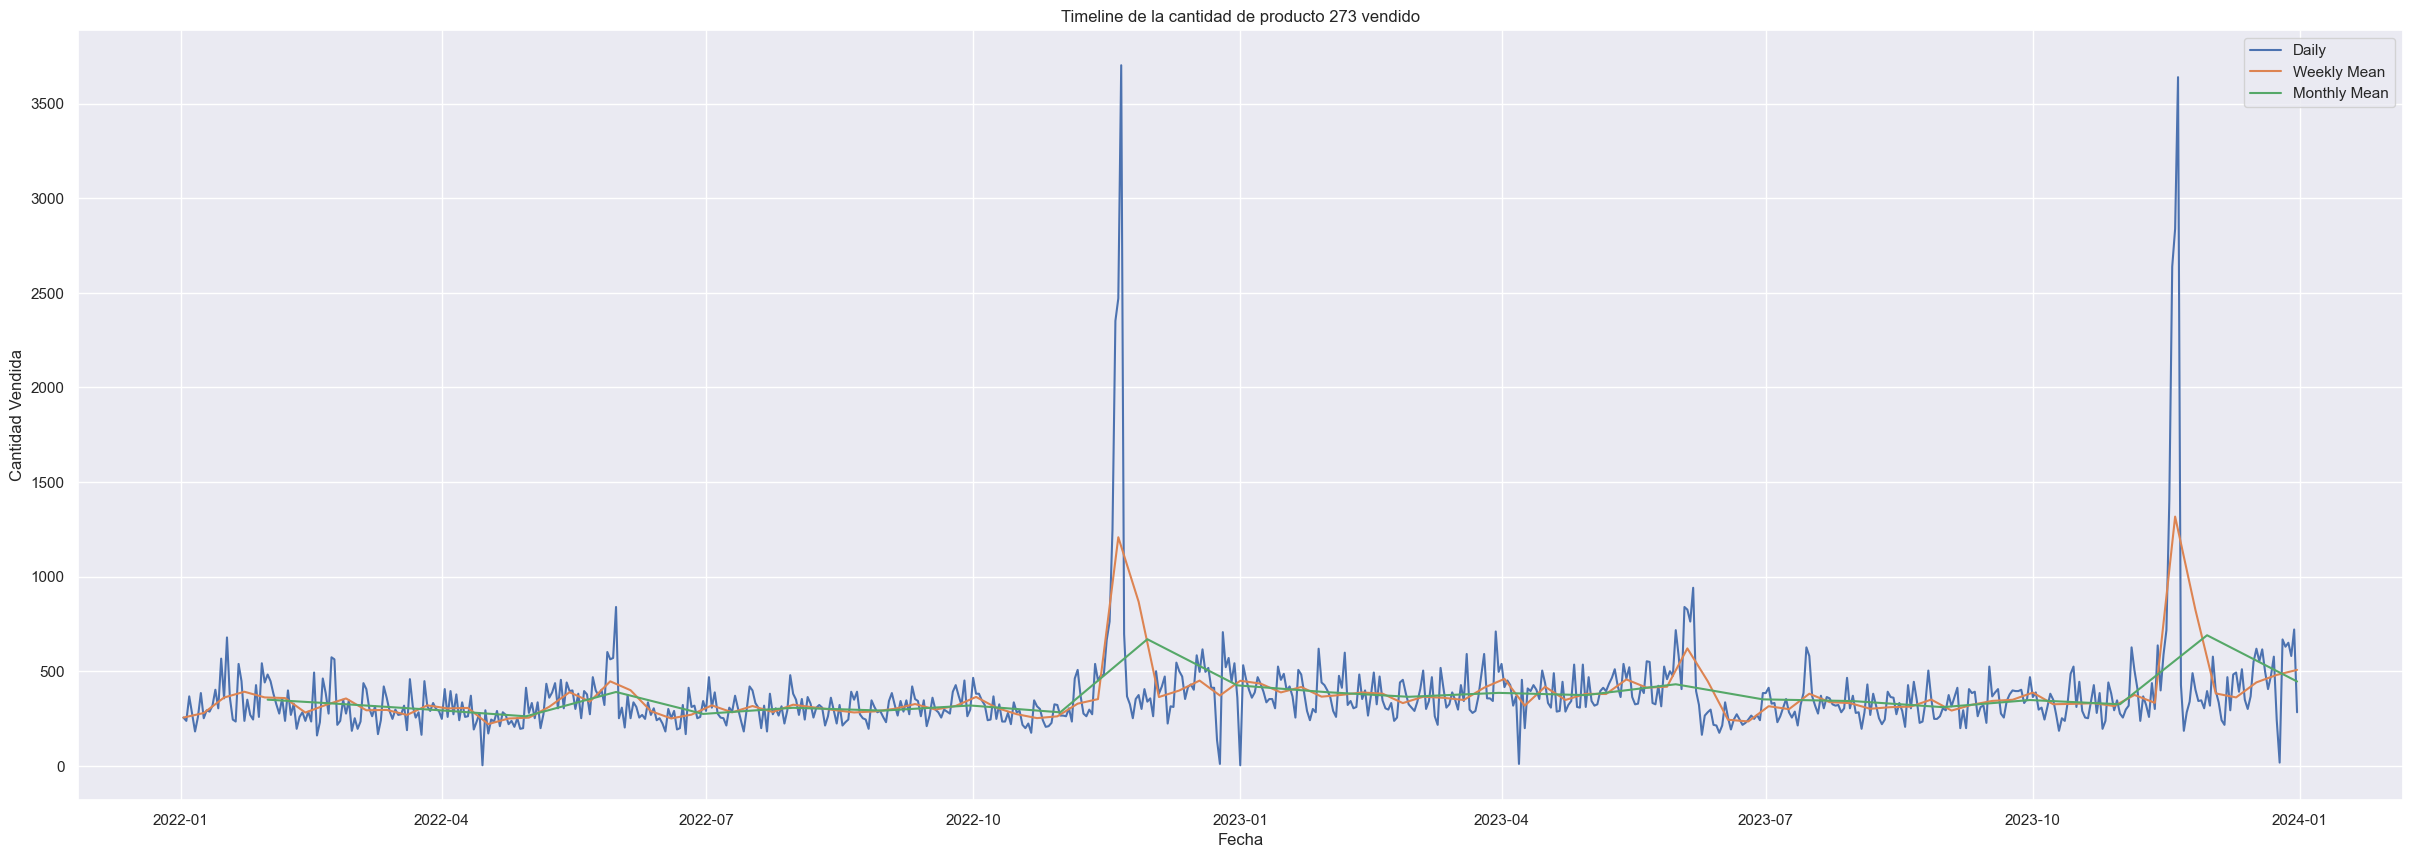

In [324]:
plt.figure(figsize=(30, 10))
plt.plot(sales_daily, label='Daily')
plt.plot(sales_weekly_mean, label='Weekly Mean')
plt.plot(sales_monthly_mean, label='Monthly Mean')
plt.title('Timeline de la cantidad de producto 273 vendido')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Vendida')
plt.legend()
plt.show()

In [325]:
sales_monthly = df_final_new.groupby([df_final_new['date'].dt.year.rename('year'), df_final_new['date'].dt.to_period("M").rename('month')])['ctdad'].sum().reset_index()
sales_monthly['month'] = sales_monthly['month'].astype(str)

In [326]:
sales_weekly = df_final_new.groupby([df_final_new['date'].dt.year.rename('year'), df_final_new['date'].dt.to_period("W").rename('week')])['ctdad'].sum().reset_index()
sales_weekly['week'] = sales_weekly['week'].astype(str)

In [327]:
sales_weekly = pd.DataFrame(df_final_new.groupby([df_final_new['date'].dt.year.rename('year'), df_final_new['date'].dt.to_period("W").rename('week')])['ctdad'].sum().reset_index().drop('year', axis=1).set_index('week'))


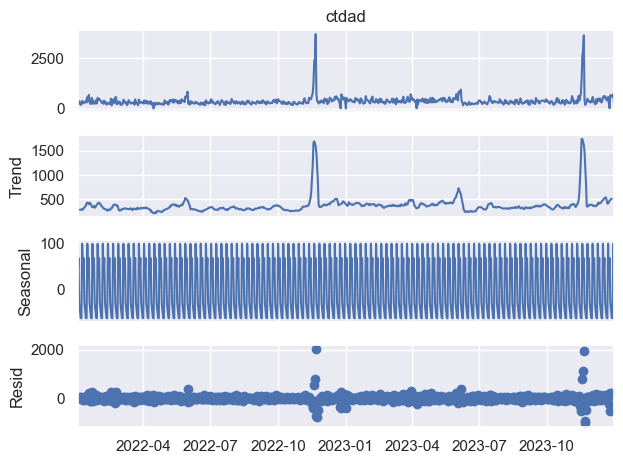

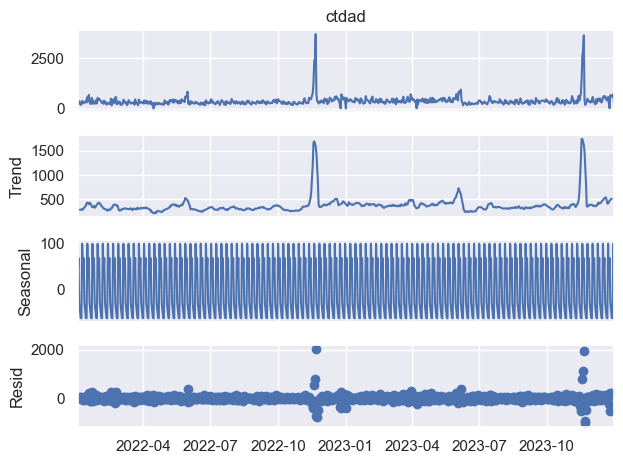

In [328]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_data = seasonal_decompose(sales_daily, model="additive")
decompose_data.plot()

In [329]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(sales_daily, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -8.208417865839433
2. P-Value :  6.923237357227161e-13
3. Num Of Lags :  7
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 721
5. Critical Values :
	 1% :  -3.4394522667904153
	 5% :  -2.8655569894909805
	 10% :  -2.568909106765338


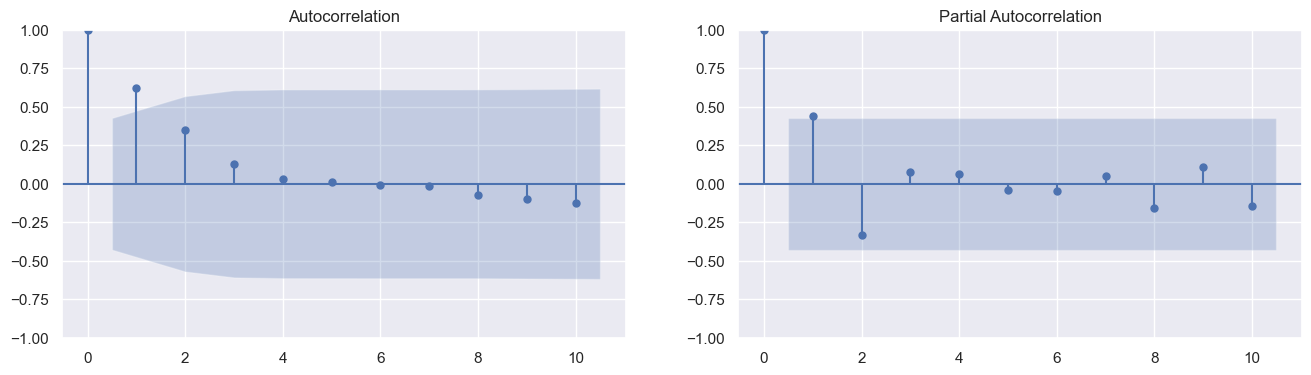

In [330]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

lag_acf = acf(sales_daily, nlags=20)
lag_pacf = pacf(sales_daily, nlags=20, method='ols')

fig, ax = plt.subplots(1,2,figsize=(16,4))
plot_acf(lag_acf, ax=ax[0])
plot_pacf(lag_pacf, ax=ax[1])


plt.show()

In [331]:
arima_model=auto_arima(sales_weekly_mean, start_p=1,d=1,start_q=1,
                      max_p=5,max_q=5,max_d=5,m=12,
                        start_P=0,D=1,start_Q=0,max_P=5,max_D=5,max_Q=5,
                      seasonal=True,
                       trace=True,
                      error_action="ignore",
                      suppress_warnings=True,
                      stepwise=True,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1248.685, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1225.619, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1216.109, Time=0.11 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1244.473, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1216.566, Time=0.18 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1217.209, Time=0.32 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1217.909, Time=0.08 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1217.769, Time=1.08 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1222.996, Time=0.08 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.17 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=inf, Time=0.17 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1222.632, Time=0.11 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : 

In [332]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  105
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -605.055
Date:                            Tue, 12 Mar 2024   AIC                           1216.109
Time:                                    19:28:51   BIC                           1223.675
Sample:                                01-02-2022   HQIC                          1219.163
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7177      0.053    -13.509      0.000      -0.822      -0.614
ma.S.L12      -0.7544      0.115     -6.578      0.000      -0.979      -0.530
sigma2      2.701e+04   1416.814     19.061      0.000    2.42e+04    2.98e+04
===================================================================================
Ljung-Box (L1) (Q):                   7.66   Jarque-Bera (JB):              1209.69
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):              11.95   Skew:                             3.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [333]:
month_number = sales_weekly_mean.index.month

# Convierte la serie de números de mes en una variable exógena DataFrame
exog_variable_month = pd.DataFrame(month_number, index=sales_weekly_mean.index)

In [334]:
exog_variables = pd.concat([exog_variable_month], axis=1)

In [335]:
from sklearn.model_selection import train_test_split
size=int(len(sales_weekly_mean)*0.66)
#train_exog, test_exog = train_test_split(exog_variables, test_size = 0.10, shuffle = False)
train_exog,test_exog=exog_variables[0:size],exog_variables[size:len(exog_variables)]

In [336]:
size=int(len(sales_weekly_mean)*0.66)
X_train,X_test=sales_weekly_mean[0:size],sales_weekly_mean[size:len(sales_weekly_mean)]

model=SARIMAX(X_train,
             exog=train_exog,
             order=(0,1,1),
             seasonal_order=(0,1,1,12))
result=model.fit()
result.summary()

c:\Users\jesus\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              ctdad   No. Observations:                   69
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -362.241
Date:                            Tue, 12 Mar 2024   AIC                            732.483
Time:                                    19:28:51   BIC                            740.584
Sample:                                01-02-2022   HQIC                           735.624
                                     - 04-23-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
date          -4.0335     65.669     -0.061      0.951    -132.743     124.676
ma.L1         -0.4547      0.100     -4.568      0.000      -0.650      -0.260
ma.S.L12      -0.9919      7.750     -0.128      0.898     -16.181      14.197
sigma2      1.693e+04    1.3e+05      0.130      0.896   -2.38e+05    2.72e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.66   Jarque-Bera (JB):              1117.47
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               1.46   Skew:                             3.15
Prob(H) (two-sided):                  0.42   Kurtosis:                        23.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [337]:
start_index=0
end_index=len(X_train)-1
train_prediction=result.predict(start_index,end_index, exog = train_exog)

st_index=len(X_train)
ed_index=len(sales_weekly_mean)-1
prediction=result.predict(st_index,ed_index, exog = test_exog)

<Axes: xlabel='date'>

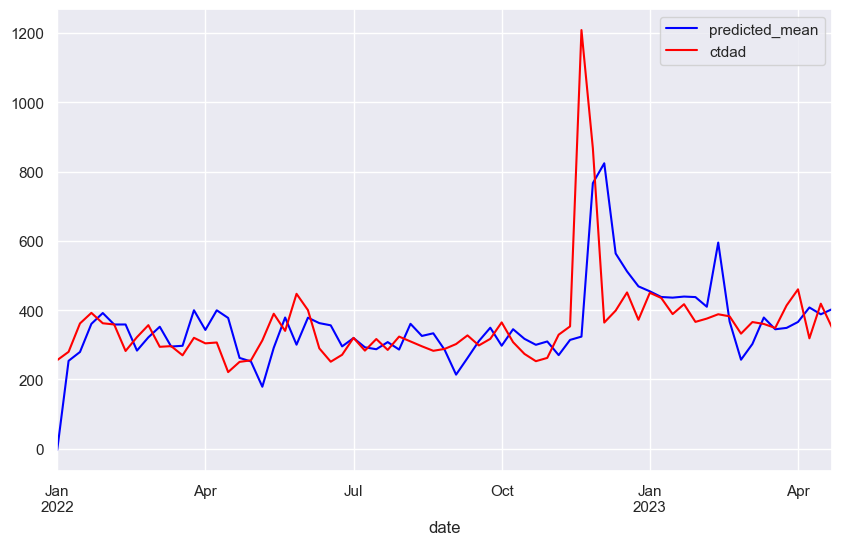

In [338]:
plt.figure(figsize=(10, 6))
train_prediction.plot(legend=True, color='blue')
X_train.plot(legend=True, color = 'red')

In [339]:
print('Absolute Error:', metrics.mean_absolute_error(X_train, train_prediction))
print('MSE:', metrics.mean_squared_error(X_train, train_prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(X_train, train_prediction)))

Absolute Error: 74.35051458014021
MSE: 19858.63645505101
RMSE: 140.92067433507054


<Axes: xlabel='date'>

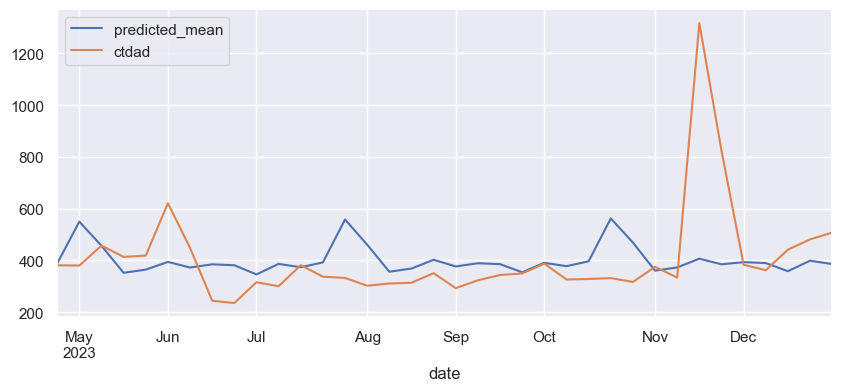

In [340]:
plt.figure(figsize=(10, 4))
prediction.plot(legend=True)
X_test.plot(legend=True)

In [341]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Suponiendo que X_test son los valores verdaderos y prediction son los valores predichos

# Calcula el MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(X_test, prediction)
print('MAPE:', mape)

# Calcula el COD (Coefficient of Determination)
cod = r2_score(X_test, prediction)
# print('COD:', cod)
print('Absolute Error:', metrics.mean_absolute_error(X_test, prediction))
print('MSE:', metrics.mean_squared_error(X_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(X_test, prediction)))

MAPE: 24.955440982135617
Absolute Error: 111.97436401732041
MSE: 38347.4083695788
RMSE: 195.82494317522168


In [342]:
date_range = pd.date_range(start='2024-01-01', periods=92, freq='W')

# Extrae el número de mes de cada fecha en el rango
exog_data = pd.DataFrame({'date': date_range})
exog_data['month'] = exog_data['date'].dt.month

# Asegúrate de que la columna 'date' sea el índice del DataFrame
exog_data.set_index('date', inplace=True)

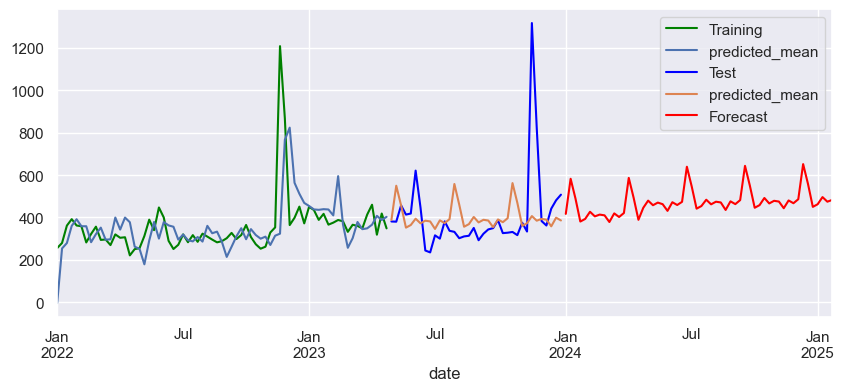

In [343]:
forecast=result.predict(len(sales_weekly_mean), (len(sales_weekly_mean)-1)+56, exog = exog_data).rename('Forecast')

plt.figure(figsize=(10,4))

X_train.plot(label="Training",color='green')
train_prediction.plot(legend=True)
X_test.plot(label="Test",color='blue')
prediction.plot(legend=True)
forecast.plot(label="Forecast",color="red")
plt.legend(loc="upper right")